# AgroVision Training Notebook

This notebook trains a U-Net model with **field-aware loss** for crop classification on the AgriFieldNet dataset.

## Training Strategy
```
L_total = 0.2 × L_pixel + 1.0 × L_field
```

| Loss | Purpose |
|------|---------|  
| **L_pixel** | Clean boundaries for overlay visualization |
| **L_field** | Match AgriFieldNet challenge scoring |

---

## Requirements
- `code.zip` - Source code
- `processed.zip` - Preprocessed data with field_ids

## Step 1: Check GPU

In [1]:
!nvidia-smi

Mon Dec 29 19:55:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Step 2: Upload and Extract Code

In [2]:
from google.colab import files
print("Please upload code.zip")
uploaded = files.upload()

Please upload code.zip


Saving code.zip to code.zip


In [3]:
!unzip -q code.zip
!ls -la

total 792
drwxr-xr-x 1 root root   4096 Dec 29 19:56 .
drwxr-xr-x 1 root root   4096 Dec 29 19:51 ..
drwxr-xr-x 4 root root   4096 Dec 29  2025 agrovision_core
-rw-r--r-- 1 root root 211438 Dec 29 19:56 code.zip
drwxr-xr-x 4 root root   4096 Dec  9 14:41 .config
drwxr-xr-x 2 root root   4096 Dec 29  2025 config
-rw-r--r-- 1 root root   3544 Dec 29 19:30 pyproject.toml
drwxr-xr-x 1 root root   4096 Dec  9 14:42 sample_data
-rw-r--r-- 1 root root 568112 Dec 29 19:30 uv.lock


## Step 3: Upload and Extract Data

In [4]:
print("Please upload processed.zip (264 MB)")
uploaded = files.upload()

Please upload processed.zip (264 MB)


Saving processed.zip to processed.zip


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!cp /content/processed.zip /content/drive/MyDrive/
!ls -lh /content/drive/MyDrive/processed.zip

-rw------- 1 root root 264M Dec 29 20:47 /content/drive/MyDrive/processed.zip


In [19]:
!unzip -q processed.zip -d .

## Step 4: Install Dependencies

In [20]:
!pip install uv -q
!uv sync

Resolved 143 packages in 2ms
Prepared 1 package in 25.74s
Installed 137 packages in 664ms
 + aenum==3.1.16
 + affine==2.4.0
 + agrovision-core==0.1.0 (from file:///content/agrovision_core)
 + aiohappyeyeballs==2.6.1
 + aiohttp==3.13.2
 + aiosignal==1.4.0
 + annotated-types==0.7.0
 + antlr4-python3-runtime==4.9.3
 + anyio==4.12.0
 + asttokens==3.0.1
 + attrs==25.4.0
 + certifi==2025.11.12
 + charset-normalizer==3.4.4
 + click==8.3.1
 + click-plugins==1.1.1.2
 + cligj==0.7.2
 + colorama==0.4.6
 + comm==0.2.3
 + contourpy==1.3.3
 + cycler==0.12.1
 + debugpy==1.8.19
 + decorator==5.2.1
 + docstring-parser==0.17.0
 + einops==0.8.1
 + executing==2.2.1
 + fastapi==0.115.5
 + filelock==3.20.1
 + fonttools==4.61.1
 + frozenlist==1.8.0
 + fsspec==2025.12.0
 + geopandas==1.1.2
 + h11==0.16.0
 + hf-xet==1.2.0
 + httpcore==1.0.9
 + httpx==0.28.1
 + huggingface-hub==1.2.3
 + hydra-core==1.3.2
 + idna==3.11
 + importlib-resources==6.5.2
 + ipykernel==7.1.0
 + ipython==9.8.0
 + ipython-pygments-lexers

## Step 5: Verify Setup

In [21]:
# Check data files exist
import os

required_files = [
    'data/processed/train_images.npy',
    'data/processed/train_masks.npy',
    'data/processed/train_field_ids.npy',
    'data/processed/val_images.npy',
    'data/processed/val_masks.npy',
    'data/processed/val_field_ids.npy',
]

print("Checking required files:")
all_ok = True
for f in required_files:
    exists = os.path.exists(f)
    status = "OK" if exists else "MISSING"
    print(f"  {status}: {f}")
    if not exists:
        all_ok = False

if all_ok:
    print("\nAll files present. Ready to train!")
else:
    print("\nSome files are missing. Please re-upload processed.zip")

Checking required files:
  OK: data/processed/train_images.npy
  OK: data/processed/train_masks.npy
  OK: data/processed/train_field_ids.npy
  OK: data/processed/val_images.npy
  OK: data/processed/val_masks.npy
  OK: data/processed/val_field_ids.npy

All files present. Ready to train!


## Step 6: Train Model

Training will run for **50 epochs** (~1-1.5 hours on T4 GPU).

**Metrics to watch:**
- `val_field_acc` - Should increase toward 0.5-0.7+
- `val_field_ce` - Should decrease (lower = better)
- `val_mIoU` - Pixel-level metric (secondary)

In [22]:
!uv run python -m agrovision_core.train.train --run-name colab_field_aware_v1

y
Epoch 000 | loss=2.0594 | val_mIoU=0.1288 | val_field_acc=0.5791 | val_field_ce=1.8339
  -> New best model! field_ce=1.8339
Epoch 001 | loss=1.6735 | val_mIoU=0.1492 | val_field_acc=0.5930 | val_field_ce=1.6152
  -> New best model! field_ce=1.6152
Epoch 002 | loss=1.4667 | val_mIoU=0.1479 | val_field_acc=0.6198 | val_field_ce=1.3942
  -> New best model! field_ce=1.3942
Epoch 003 | loss=1.3086 | val_mIoU=0.1496 | val_field_acc=0.6050 | val_field_ce=1.4134
Epoch 004 | loss=1.2653 | val_mIoU=0.1337 | val_field_acc=0.5782 | val_field_ce=1.3051
  -> New best model! field_ce=1.3051
Epoch 005 | loss=1.1946 | val_mIoU=0.1657 | val_field_acc=0.6216 | val_field_ce=1.2560
  -> New best model! field_ce=1.2560
Epoch 006 | loss=1.1745 | val_mIoU=0.1520 | val_field_acc=0.6253 | val_field_ce=1.1902
  -> New best model! field_ce=1.1902
Epoch 007 | loss=1.0906 | val_mIoU=0.1504 | val_field_acc=0.6226 | val_field_ce=1.1257
  -> New best model! field_ce=1.1257
Epoch 008 | loss=1.0370 | val_mIoU=0.1546 |

## Step 7: View Training Results

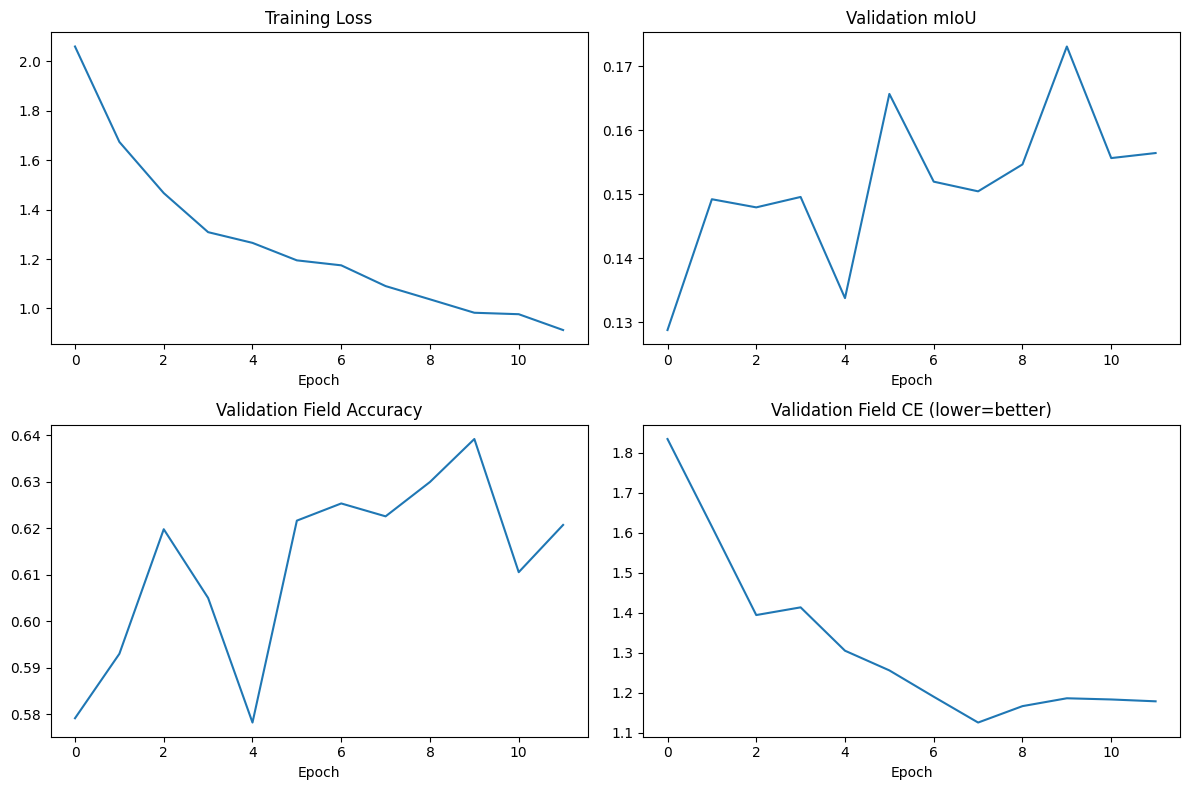


Best model at epoch 7:
  Field Accuracy: 0.6226
  Field CE: 1.1257
  mIoU: 0.1504


In [23]:
import json
import matplotlib.pyplot as plt

# Load metrics
metrics_path = 'outputs/runs/colab_field_aware_v1/metrics.jsonl'
metrics = []
with open(metrics_path, 'r') as f:
    for line in f:
        metrics.append(json.loads(line))

# Extract values
epochs = [m['epoch'] for m in metrics]
train_loss = [m['train_loss'] for m in metrics]
val_miou = [m['val_mIoU'] for m in metrics]
val_field_acc = [m['val_field_accuracy'] for m in metrics]
val_field_ce = [m['val_field_ce'] for m in metrics]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(epochs, train_loss)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')

axes[0, 1].plot(epochs, val_miou)
axes[0, 1].set_title('Validation mIoU')
axes[0, 1].set_xlabel('Epoch')

axes[1, 0].plot(epochs, val_field_acc)
axes[1, 0].set_title('Validation Field Accuracy')
axes[1, 0].set_xlabel('Epoch')

axes[1, 1].plot(epochs, val_field_ce)
axes[1, 1].set_title('Validation Field CE (lower=better)')
axes[1, 1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

# Print best results
best_idx = val_field_ce.index(min(val_field_ce))
print(f"\nBest model at epoch {epochs[best_idx]}:")
print(f"  Field Accuracy: {val_field_acc[best_idx]:.4f}")
print(f"  Field CE: {val_field_ce[best_idx]:.4f}")
print(f"  mIoU: {val_miou[best_idx]:.4f}")

## Step 8: Download Trained Model

In [24]:
from google.colab import files

# Download best model
model_path = 'outputs/models/unet_baseline_best_model.pth'
print(f"Downloading {model_path}...")
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Optional: Download metrics log
files.download('outputs/runs/colab_field_aware_v1/metrics.jsonl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
!cp /content/outputs/models/unet_baseline_best_model.pth /content/drive/MyDrive/

## Done!

Your trained model is downloaded. Place it in:
```
outputs/models/unet_baseline_best_model.pth
```

Then run the backend to test inference:
```bash
uvicorn backend.main:app --reload
```